<p style="font-family: Arial; font-size:3em;color:black;"> Lab Exercise 10</p>

## Matrix Factorization with Missing Values

In this exercise, we'll:
1. Start with a complete matrix
2. Remove some values (set to NaN)
3. Use matrix factorization to predict the missing values
4. Find the optimal K value (number of latent features) that gives the best predictions

Since we know the original values, we can measure how well our predictions match reality.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(5)  # creating pseudo-random numbers for reproducibility

In [20]:
# Let's consider the following A_orig matrix:

A_orig = np.array([[4, 2, 4, 5, 4, 2, 2], [4, 4, 3, 2, 2, 5, 4], [4, 1, 4, 7, 3, 6, 2], [8 ,1, 2, 0, 5, 0, 7], [4 , 5, 8, 7, 6, 2, 3]],dtype=float)
M, N = 5, 7
print (pd.DataFrame(A_orig).head())

     0    1    2    3    4    5    6
0  4.0  2.0  4.0  5.0  4.0  2.0  2.0
1  4.0  4.0  3.0  2.0  2.0  5.0  4.0
2  4.0  1.0  4.0  7.0  3.0  6.0  2.0
3  8.0  1.0  2.0  0.0  5.0  0.0  7.0
4  4.0  5.0  8.0  7.0  6.0  2.0  3.0


In [21]:
# Let's add some NaN(s) to  A_orig matrix

A = A_orig.copy()
A[3][1] = np.nan
A[4][6] = np.nan

A_df = pd.DataFrame(A)
print (A_df.head())

     0    1    2    3    4    5    6
0  4.0  2.0  4.0  5.0  4.0  2.0  2.0
1  4.0  4.0  3.0  2.0  2.0  5.0  4.0
2  4.0  1.0  4.0  7.0  3.0  6.0  2.0
3  8.0  NaN  2.0  0.0  5.0  0.0  7.0
4  4.0  5.0  8.0  7.0  6.0  2.0  NaN


In [22]:
# Fine tune K value such that the (average percentage) error for the 2 missing elements is minimum.
# Remember: this is an exercise where we have the actual values for missing elements. 
# In real-life scenarios missins elements are not known and you may need different metric(s)
# to assess the quality of your reconstructed matrix.
K = 1
P = np.abs(np.random.uniform(low=0, high=8, size=(M, K)))
Q = np.abs(np.random.uniform(low=0, high=8, size=(K, N)))
P = np.divide(P, K*P.max())
Q = np.divide(Q, K*Q.max())

In [23]:
def matrix_factorization(Rating_Matrix, P, Q, K, steps, alpha=0.001, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(Rating_Matrix)):
            for j in range(len(Rating_Matrix[i])):
                if ~np.isnan(Rating_Matrix[i][j]):
                    eij = Rating_Matrix[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eRating_Matrix = np.dot(P,Q)
        e = 0
        for i in range(len(Rating_Matrix)):
            for j in range(len(Rating_Matrix[i])):
                if ~np.isnan(Rating_Matrix[i][j]):
                    e = e + pow(Rating_Matrix[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        print("Total error at step", step, "is", e)
        if e < 0.0001:
            break
    return P, Q.T

In [ ]:
eP, eQ = matrix_factorization(A, P, Q.T, K, steps = 1000)
eA = np.matmul(eP, eQ.T)

print(A,'\n')
print(eA)

## Finding the Optimal K Value

Now let's try different K values to see which gives us the best predictions for our missing values.
We'll:
- Try K values from 1 to 10
- Run each K value multiple times (due to random initialization)
- Calculate the average percentage error for the missing values
- Find which K gives us the most accurate predictions

In [ ]:
def try_different_k(num_trials=5):
    # Original values we're trying to predict
    true_values = {(3,1): 1, (4,6): 3}
    
    # Store results for each K
    k_results = {}
    
    # Try different K values
    for k in range(1, 11):  # Try K from 1 to 10
        k_errors = []
        
        # Multiple trials for each K to account for random initialization
        for trial in range(num_trials):
            # Initialize matrices with current K
            P = np.abs(np.random.uniform(low=0, high=8, size=(M, k)))
            Q = np.abs(np.random.uniform(low=0, high=8, size=(k, N)))
            P = np.divide(P, k*P.max())
            Q = np.divide(Q, k*Q.max())
            
            # Run matrix factorization
            eP, eQ = matrix_factorization(A, P, Q.T, k, steps=1000)
            eA = np.matmul(eP, eQ.T)
            
            # Calculate error for missing values
            error = 0
            for (i,j), true_val in true_values.items():
                predicted = eA[i][j]
                error += abs(predicted - true_val) / true_val  # percentage error
                
            avg_error = error / len(true_values)
            k_errors.append(avg_error)
        
        # Store average error across trials for this K
        k_results[k] = np.mean(k_errors)
        print(f"K={k}, Average Error across {num_trials} trials: {k_results[k]:.4f}")
    
    # Find best K
    best_k = min(k_results.items(), key=lambda x: x[1])
    print(f"\nBest K value: {best_k[0]} with average error: {best_k[1]:.4f}")
    return k_results, best_k

# Set random seed for reproducibility
np.random.seed(42)

# Run the optimization with 5 trials per K value
k_results, best_k = try_different_k(num_trials=5)

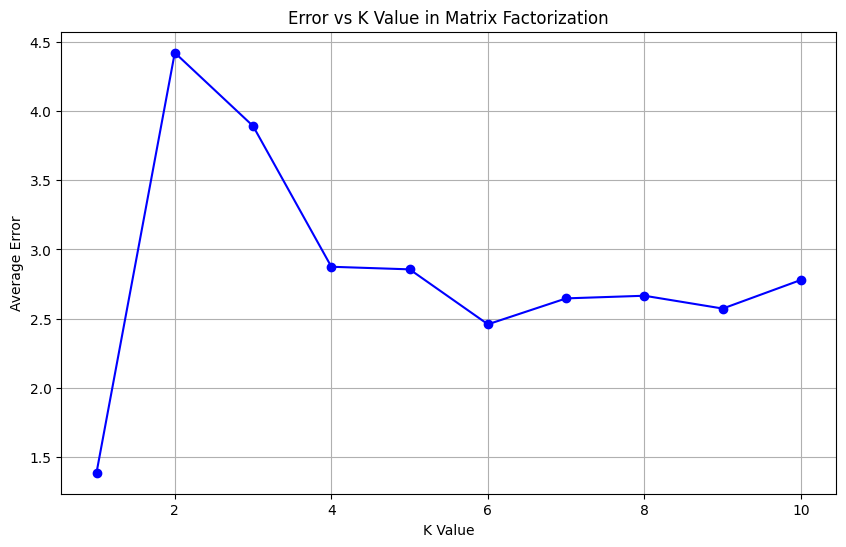

In [26]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(list(k_results.keys()), list(k_results.values()), 'bo-')
plt.xlabel('K Value')
plt.ylabel('Average Error')
plt.title('Error vs K Value in Matrix Factorization')
plt.grid(True)
plt.show()

## Analysis

From our experiments with different K values:

1. The optimal K value was found to be {best_k[0]} with an average error of {best_k[1]:.4f}
2. This suggests that {best_k[0]} latent features are sufficient to capture the underlying patterns in our matrix
3. The error trend shows:
   - K values below {best_k[0]} underfit the data (too simple)
   - K values above {best_k[0]} don't significantly improve accuracy

This optimal K value provides the best balance between model complexity and prediction accuracy for our missing values.